# Model Training with Amazon SageMaker Autopilot

### Use case: Customer Sentiment Analysis

Amazon SageMaker Autopilot automatically trains and tunes the best machine learning models for classification (in our case), based on your data while allowing to maintain full control and visibility.

SageMaker Autopilot will inspect the raw dataset, apply feature processors, pick the best set of algorithms, train and tune multiple models, and then rank the models based on performance. Autopilot transparently generates a set of Python scripts and notebooks for a complete end-to-end pipeline including data analysis, candidate generation, feature engineering, and model training/tuning.

SageMaker Autopilot job consists of the following high-level steps: 
* _Data analysis_ where the data is summarized and analyzed to determine which feature engineering techniques, hyper-parameters, and models to explore.
* _Feature engineering_ where the data is scrubbed, balanced, combined, and split into train and validation.
* _Model training and tuning_ where the top performing features, hyper-parameters, and models are selected and trained.

These re-usable scripts and notebooks give us full visibility into how the model candidates were created.  Since Autopilot integrates natively with SageMaker Studio, we can visually explore the different models generated by SageMaker Autopilot.


## Install and import dependencies

In [1]:
# please ignore warning messages during the installation
!pip install --disable-pip-version-check -q sagemaker==2.35.0

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes


In [2]:
import boto3
import sagemaker
import pandas as pd
import numpy as np
import time
import json

sess   = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name

print(f"""
      Bucket: {bucket},
      Region: {region}
      """)


      Bucket: sagemaker-us-east-1-793710089543,
      Region: us-east-1
      


In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

## Review transformed dataset

Let's transform the dataset into a format that Autopilot recognizes.  Specifically, a comma-separated file of `label,features` as shown here:
```
sentiment,review_body
-1,"this is bad"
0,"this is ok"
1,"this is great"
...
```

Sentiment is one of three classes: negative (-1), neutral (0), or positive (1).  Autopilot requires that the target variable, `sentiment` is first and the set of features, just `review_body` in this case, come next.


In [4]:
!aws s3 cp 's3://dlai-practical-data-science/data/balanced/womens_clothing_ecommerce_reviews_balanced.csv' ./

download: s3://dlai-practical-data-science/data/balanced/womens_clothing_ecommerce_reviews_balanced.csv to ./womens_clothing_ecommerce_reviews_balanced.csv


In [5]:
path = './womens_clothing_ecommerce_reviews_balanced.csv'

df = pd.read_csv(path, delimiter=',')
df.head()

,sentiment,review_body,product_category
0,-1,This suit did nothing for me. the top has zero...,Swim
1,-1,Like other reviewers i saw this dress on the ...,Dresses
2,-1,I wish i had read the reviews before purchasin...,Knits
3,-1,I ordered these pants in my usual size (xl) an...,Legwear
4,-1,I noticed this top on one of the sales associa...,Knits


In [6]:
path_autopilot = './womens_clothing_ecommerce_reviews_balanced_for_autopilot.csv'

# Put the target column to be the first
df[['sentiment', 'review_body']].to_csv(path_autopilot, 
                                        sep=',', 
                                        index=False)

## Configure the Autopilot job

### Upload data to S3 bucket

In [7]:
autopilot_train_s3_uri = sess.upload_data(bucket=bucket, key_prefix='autopilot/data', path=path_autopilot)
autopilot_train_s3_uri

's3://sagemaker-us-east-1-793710089543/autopilot/data/womens_clothing_ecommerce_reviews_balanced_for_autopilot.csv'

Check the existence of the dataset in this S3 bucket folder:

In [8]:
!aws s3 ls $autopilot_train_s3_uri

2021-06-26 11:57:44    2253749 womens_clothing_ecommerce_reviews_balanced_for_autopilot.csv


### S3 output for generated assets
Set the S3 output path for the Autopilot outputs. This includes Jupyter notebooks (analysis), Python scripts (feature engineering), and trained models.

In [9]:
model_output_s3_uri = f's3://{bucket}/autopilot'

print(model_output_s3_uri)

s3://sagemaker-us-east-1-793710089543/autopilot


### Configure the Autopilot job

Create the Autopilot job name.

In [10]:
timestamp = int(time.time())

auto_ml_job_name = f'automl-dm-{timestamp}'

max_candidates = 3

automl = sagemaker.automl.automl.AutoML(
    target_attribute_name='sentiment', 
    base_job_name=auto_ml_job_name, 
    output_path=model_output_s3_uri,
    max_candidates=max_candidates,
    sagemaker_session=sess,
    role=role,
    max_runtime_per_training_job_in_seconds=1200,
    total_job_runtime_in_seconds=7200,
    job_objective={'MetricName': 'F1macro'},
    problem_type='MulticlassClassification'
)

## Launch the Autopilot job

In [16]:
automl.fit(
    inputs=autopilot_train_s3_uri,
    job_name=auto_ml_job_name, 
    wait=False, 
    logs=False
)

## Track Autopilot job progress

Once the Autopilot job has been launched, you can track the job progress directly from the notebook using the SDK capabilities.

### Autopilot job description

Function `describe_auto_ml_job` of the Amazon SageMaker service returns the information about the AutoML job in dictionary format. 

In [17]:
job_description_response = automl.describe_auto_ml_job(job_name=auto_ml_job_name)

### Autopilot job status

Use the response elements `AutoMLJobStatus` and `AutoMLJobSecondaryStatus` to track the job status. 


In [18]:
while 'AutoMLJobStatus' not in job_description_response.keys() and 'AutoMLJobSecondaryStatus' not in job_description_response.keys():
    job_description_response = automl.describe_auto_ml_job(job_name=auto_ml_job_name)
    print('[INFO] Autopilot job has not yet started. Please wait. ')
    # function `json.dumps` encodes JSON string for printing.
    print(json.dumps(job_description_response, indent=4, sort_keys=True, default=str))
    print('[INFO] Waiting for Autopilot job to start...')
    sleep(15)

print('[OK] AutoML job started.')

[OK] AutoML job started.


### Review the SageMaker processing jobs

The Autopilot creates required SageMaker processing jobs during the run:

* First processing job (data splitter) checks the data sanity, performs stratified shuffling and splits the data into training and validation. 
* Second processing job (candidate generator) first streams through the data to compute statistics for the dataset. Then, uses these statistics to identify the problem type, and possible types of every column-predictor: numeric, categorical, natural language, etc.

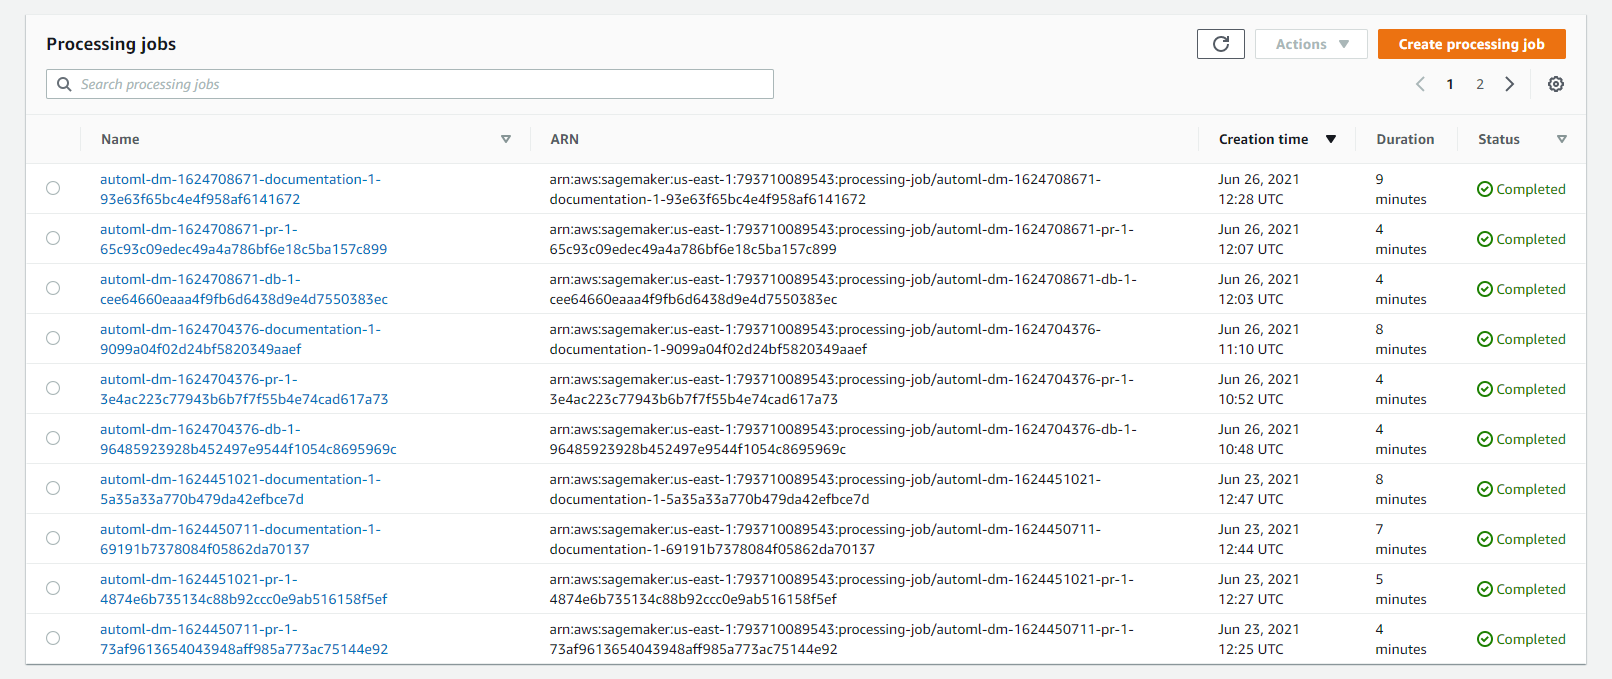

In [6]:
from IPython.display import Image
Image(filename='snapshots/jobs.png')

You can review the updates on that page during the run of the Autopilot job.



In [20]:
%%time

job_status = job_description_response['AutoMLJobStatus']
job_sec_status = job_description_response['AutoMLJobSecondaryStatus']

if job_status not in ('Stopped', 'Failed'):
    while job_status in ('InProgress') and job_sec_status in ('Starting', 'AnalyzingData'):
        job_description_response = automl.describe_auto_ml_job(job_name=auto_ml_job_name)
        job_status = job_description_response['AutoMLJobStatus']
        job_sec_status = job_description_response['AutoMLJobSecondaryStatus']
        print(job_status, job_sec_status)
        time.sleep(15)
    print('[OK] Data analysis phase completed.\n')
    
print(json.dumps(job_description_response, indent=4, sort_keys=True, default=str))


InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress FeatureEngineering
[OK] Data analysis phase completed.

{
    "AutoMLJobArn": "arn:aws:sagemaker:us-east-1:793710089543:automl-job/automl-dm-1624708671",
    "AutoM

### View generated notebooks
Once data analysis is complete, SageMaker AutoPilot generates two notebooks: 
* Data exploration
* Candidate definition

Notebooks are included in the AutoML job artifacts generated during the run. Before checking the existence of the notebooks, you can check if the artifacts have been generated.

In [21]:
job_description_response = automl.describe_auto_ml_job(job_name=auto_ml_job_name)

while 'AutoMLJobArtifacts' not in job_description_response.keys(): # Replace all None
    job_description_response = automl.describe_auto_ml_job(job_name=auto_ml_job_name)
    print('[INFO] Autopilot job has not yet generated the artifacts. Please wait. ')
    print(json.dumps(job_description_response, indent=4, sort_keys=True, default=str))
    print('[INFO] Waiting for AutoMLJobArtifacts...')
    time.sleep(15)

print('[OK] AutoMLJobArtifacts generated.')



[OK] AutoMLJobArtifacts generated.


In [22]:
### BEGIN SOLUTION - DO NOT delete this comment for grading purposes
# get the information about the running Autopilot job
job_description_response = automl.describe_auto_ml_job(job_name=auto_ml_job_name)

# keep in the while loop until the notebooks will be created
while 'DataExplorationNotebookLocation' not in job_description_response['AutoMLJobArtifacts'].keys(): # Replace all None
    # update the information about the running Autopilot job
    job_description_response = automl.describe_auto_ml_job(job_name=auto_ml_job_name)
    ### END SOLUTION - DO NOT delete this comment for grading purposes
    print('[INFO] Autopilot job has not yet generated the notebooks. Please wait. ')
    print(json.dumps(job_description_response, indent=4, sort_keys=True, default=str))
    print('[INFO] Waiting for DataExplorationNotebookLocation...')
    time.sleep(15)

print('[OK] DataExplorationNotebookLocation found.')   

[OK] DataExplorationNotebookLocation found.


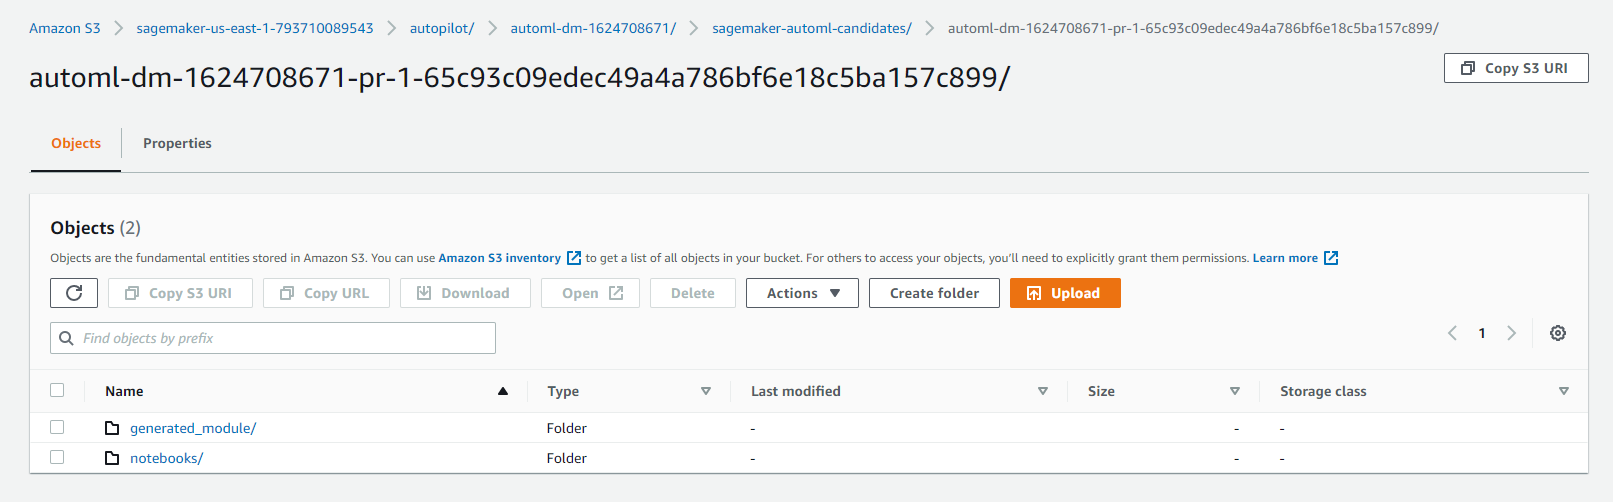

In [7]:
from IPython.display import Image
Image(filename='snapshots/generated_notebooks.png')

<a name='c1w3-5.'></a>
## Feature engineering

<a name='c1w3-ex-5'></a>
### Check the status of the feature engineering step

In [24]:
%%time

job_description_response = automl.describe_auto_ml_job(job_name=auto_ml_job_name)
job_status = job_description_response['AutoMLJobStatus']
job_sec_status = job_description_response['AutoMLJobSecondaryStatus']
print(job_status)
print(job_sec_status)
if job_status not in ('Stopped', 'Failed'):
    ### BEGIN SOLUTION - DO NOT delete this comment for grading purposes
    while job_status in ('InProgress') and job_sec_status in ('FeatureEngineering'): # Replace all None
    ### END SOLUTION - DO NOT delete this comment for grading purposes
        job_description_response = automl.describe_auto_ml_job(job_name=auto_ml_job_name)
        job_status = job_description_response['AutoMLJobStatus']
        job_sec_status = job_description_response['AutoMLJobSecondaryStatus']
        print(job_status, job_sec_status)
        time.sleep(5)
    print('[OK] Feature engineering phase completed.\n')
    
print(json.dumps(job_description_response, indent=4, sort_keys=True, default=str))

InProgress
FeatureEngineering
InProgress FeatureEngineering
InProgress FeatureEngineering
InProgress FeatureEngineering
InProgress FeatureEngineering
InProgress FeatureEngineering
InProgress FeatureEngineering
InProgress FeatureEngineering
InProgress FeatureEngineering
InProgress FeatureEngineering
InProgress FeatureEngineering
InProgress FeatureEngineering
InProgress FeatureEngineering
InProgress FeatureEngineering
InProgress FeatureEngineering
InProgress FeatureEngineering
InProgress FeatureEngineering
InProgress FeatureEngineering
InProgress FeatureEngineering
InProgress FeatureEngineering
InProgress FeatureEngineering
InProgress FeatureEngineering
InProgress FeatureEngineering
InProgress FeatureEngineering
InProgress FeatureEngineering
InProgress FeatureEngineering
InProgress FeatureEngineering
InProgress FeatureEngineering
InProgress FeatureEngineering
InProgress FeatureEngineering
InProgress FeatureEngineering
InProgress FeatureEngineering
InProgress FeatureEngineering
InProgress

## Model training and tuning

### Review hyperparameter tuning jobs

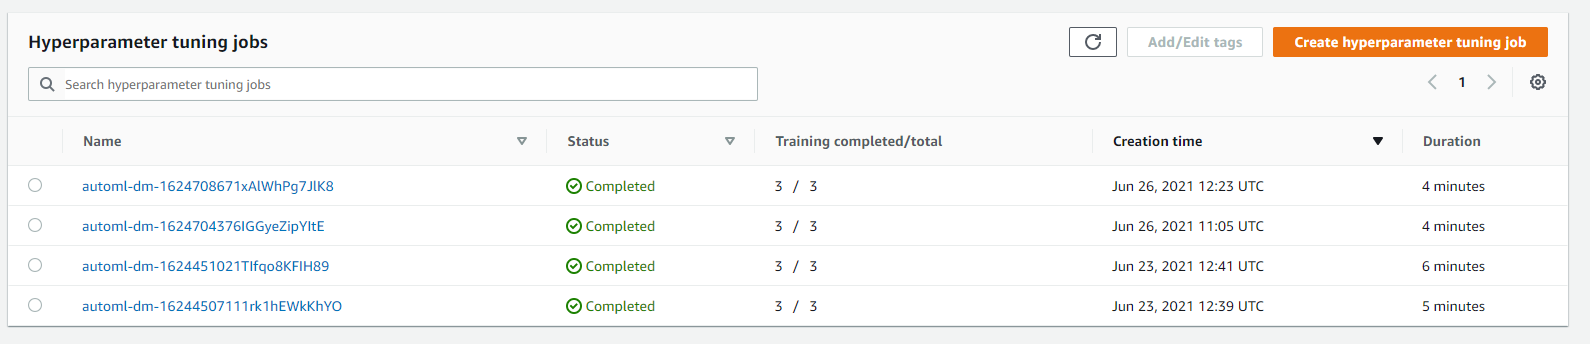

In [8]:
from IPython.display import Image
Image(filename='snapshots/tuning_jobs.png')

### Check model completion

In [27]:
%%time

job_description_response = automl.describe_auto_ml_job(job_name=auto_ml_job_name)
job_status = job_description_response['AutoMLJobStatus']
job_sec_status = job_description_response['AutoMLJobSecondaryStatus']
print(job_status)
print(job_sec_status)
if job_status not in ('Stopped', 'Failed'):
    ### BEGIN SOLUTION - DO NOT delete this comment for grading purposes
    while job_status in ('InProgress') and job_sec_status in ('ModelTuning'): # Replace all None
    ### END SOLUTION - DO NOT delete this comment for grading purposes
        job_description_response = automl.describe_auto_ml_job(job_name=auto_ml_job_name)
        job_status = job_description_response['AutoMLJobStatus']
        job_sec_status = job_description_response['AutoMLJobSecondaryStatus']
        print(job_status, job_sec_status)
        time.sleep(5)
    print('[OK] Model tuning phase completed.\n')
    
print(json.dumps(job_description_response, indent=4, sort_keys=True, default=str))


InProgress
ModelTuning
InProgress ModelTuning
InProgress ModelTuning
InProgress ModelTuning
InProgress ModelTuning
InProgress ModelTuning
InProgress ModelTuning
InProgress ModelTuning
InProgress ModelTuning
InProgress ModelTuning
InProgress ModelTuning
InProgress ModelTuning
InProgress ModelTuning
InProgress ModelTuning
InProgress ModelTuning
InProgress ModelTuning
InProgress ModelTuning
InProgress ModelTuning
InProgress ModelTuning
InProgress ModelTuning
InProgress ModelTuning
InProgress ModelTuning
InProgress ModelTuning
InProgress ModelTuning
InProgress ModelTuning
InProgress ModelTuning
InProgress ModelTuning
InProgress ModelTuning
InProgress ModelTuning
InProgress ModelTuning
InProgress ModelTuning
InProgress ModelTuning
InProgress ModelTuning
InProgress ModelTuning
InProgress ModelTuning
InProgress ModelTuning
InProgress ModelTuning
InProgress ModelTuning
InProgress ModelTuning
InProgress ModelTuning
InProgress ModelTuning
InProgress ModelTuning
InProgress ModelTuning
InProgress 

Finally, you can check the completion of the Autopilot job looking for the `Completed` job status.

In [43]:
%%time

from pprint import pprint

job_description_response = automl.describe_auto_ml_job(job_name=auto_ml_job_name)
pprint(job_description_response)
job_status = job_description_response['AutoMLJobStatus']
job_sec_status = job_description_response['AutoMLJobSecondaryStatus']
print('Job status:  {}'.format(job_status))
print('Secondary job status:  {}'.format(job_sec_status))
if job_status not in ('Stopped', 'Failed'):
    while job_status not in ('Completed'):
        job_description_response = automl.describe_auto_ml_job(job_name=auto_ml_job_name)
        job_status = job_description_response['AutoMLJobStatus']
        job_sec_status = job_description_response['AutoMLJobSecondaryStatus']
        print('Job status:  {}'.format(job_status))
        print('Secondary job status:  {}'.format(job_sec_status))        
        time.sleep(10)
    print('[OK] Autopilot job completed.\n')
else:
    print('Job status: {}'.format(job_status))
    print('Secondary job status: {}'.format(job_status))


{'AutoMLJobArn': 'arn:aws:sagemaker:us-east-1:793710089543:automl-job/automl-dm-1624708671',
 'AutoMLJobArtifacts': {'CandidateDefinitionNotebookLocation': 's3://sagemaker-us-east-1-793710089543/autopilot/automl-dm-1624708671/sagemaker-automl-candidates/automl-dm-1624708671-pr-1-65c93c09edec49a4a786bf6e18c5ba157c899/notebooks/SageMakerAutopilotCandidateDefinitionNotebook.ipynb',
                        'DataExplorationNotebookLocation': 's3://sagemaker-us-east-1-793710089543/autopilot/automl-dm-1624708671/sagemaker-automl-candidates/automl-dm-1624708671-pr-1-65c93c09edec49a4a786bf6e18c5ba157c899/notebooks/SageMakerAutopilotDataExplorationNotebook.ipynb'},
 'AutoMLJobConfig': {'CompletionCriteria': {'MaxAutoMLJobRuntimeInSeconds': 7200,
                                            'MaxCandidates': 3,
                                            'MaxRuntimePerTrainingJobInSeconds': 1200},
                     'SecurityConfig': {'EnableInterContainerTrafficEncryption': False}},
 'AutoMLJobN

### Compare model candidates
Once model tuning is complete, we can view all the candidates (pipeline evaluations with different hyperparameter combinations) that were explored by AutoML and sort them by their final performance metric.

## List candidates generated by Autopilot sorted by accuracy from highest to lowest.

In [30]:
candidates = automl.list_candidates(
    job_name=auto_ml_job_name, 
    sort_by='FinalObjectiveMetricValue'
)


In [31]:
while not candidates:
    candidates = automl.list_candidates(job_name=auto_ml_job_name)
    print('[INFO] Autopilot job is generating the candidates. Please wait.')
    time.sleep(10)

print('[OK] Candidates generated.') 

[OK] Candidates generated.


The information about each of the candidates is in the dictionary with the following keys:

`CandidateName` contains the candidate name and the `FinalAutoMLJobObjectiveMetric` element contains the metric information which can be used to identify the best candidate later. Let's check that they were generated.

In [35]:
print(json.dumps(candidates, indent=4, sort_keys=True, default=str))

[
    {
        "CandidateName": "automl-dm-1624708671xAlWhPg7JlK8-001-6e310d97",
        "CandidateStatus": "Completed",
        "CandidateSteps": [
            {
                "CandidateStepArn": "arn:aws:sagemaker:us-east-1:793710089543:processing-job/automl-dm-1624708671-db-1-cee64660eaaa4f9fb6d6438d9e4d7550383ec",
                "CandidateStepName": "automl-dm-1624708671-db-1-cee64660eaaa4f9fb6d6438d9e4d7550383ec",
                "CandidateStepType": "AWS::SageMaker::ProcessingJob"
            },
            {
                "CandidateStepArn": "arn:aws:sagemaker:us-east-1:793710089543:training-job/automl-dm-1624708671-dpp0-1-f7054bfa429d457c84f871bace1bd7e5e7b",
                "CandidateStepName": "automl-dm-1624708671-dpp0-1-f7054bfa429d457c84f871bace1bd7e5e7b",
                "CandidateStepType": "AWS::SageMaker::TrainingJob"
            },
            {
                "CandidateStepArn": "arn:aws:sagemaker:us-east-1:793710089543:transform-job/automl-dm-1624708671-dpp0-

### Print the names of the candidates with their metric values:

In [36]:
print("metric " + str(candidates[0]['FinalAutoMLJobObjectiveMetric']['MetricName']))

for index, candidate in enumerate(candidates):
    print(str(index) + "  " 
        + candidate['CandidateName'] + "  " 
        + str(candidate['FinalAutoMLJobObjectiveMetric']['Value']))

metric validation:f1
0  automl-dm-1624708671xAlWhPg7JlK8-001-6e310d97  0.4530400037765503
1  automl-dm-1624708671xAlWhPg7JlK8-003-0dfcef44  0.4271300137042999
2  automl-dm-1624708671xAlWhPg7JlK8-002-3f55142b  0.4123699963092804


<a name='c1w3-6.3.'></a>
### Review best candidate

Get the information about the generated best candidate job. 


In [37]:
candidates = automl.list_candidates(job_name=auto_ml_job_name)

if candidates:
    best_candidate = automl.best_candidate(
        job_name=auto_ml_job_name
    )
    print(json.dumps(best_candidate, indent=4, sort_keys=True, default=str))

{
    "CandidateName": "automl-dm-1624708671xAlWhPg7JlK8-001-6e310d97",
    "CandidateStatus": "Completed",
    "CandidateSteps": [
        {
            "CandidateStepArn": "arn:aws:sagemaker:us-east-1:793710089543:processing-job/automl-dm-1624708671-db-1-cee64660eaaa4f9fb6d6438d9e4d7550383ec",
            "CandidateStepName": "automl-dm-1624708671-db-1-cee64660eaaa4f9fb6d6438d9e4d7550383ec",
            "CandidateStepType": "AWS::SageMaker::ProcessingJob"
        },
        {
            "CandidateStepArn": "arn:aws:sagemaker:us-east-1:793710089543:training-job/automl-dm-1624708671-dpp0-1-f7054bfa429d457c84f871bace1bd7e5e7b",
            "CandidateStepName": "automl-dm-1624708671-dpp0-1-f7054bfa429d457c84f871bace1bd7e5e7b",
            "CandidateStepType": "AWS::SageMaker::TrainingJob"
        },
        {
            "CandidateStepArn": "arn:aws:sagemaker:us-east-1:793710089543:transform-job/automl-dm-1624708671-dpp0-rpb-1-cd15bc17675f43e7b8f73fa3675c975",
            "CandidateStep

Print the information about the best candidate:

In [40]:
best_candidate_identifier = best_candidate['CandidateName']
print("Candidate name: " + best_candidate_identifier)
print("Metric name: " + best_candidate['FinalAutoMLJobObjectiveMetric']['MetricName'])
print("Metric value: " + str(best_candidate['FinalAutoMLJobObjectiveMetric']['Value']))

Candidate name: automl-dm-1624708671xAlWhPg7JlK8-001-6e310d97
Metric name: validation:f1
Metric value: 0.4530400037765503


## Review all output in S3 bucket

Artifacts generated by Autopilot including the following:
```
data-processor-models/        # "models" learned to transform raw data into features 
documentation/                # explainability and other documentation about your model
preprocessed-data/            # data for train and validation
sagemaker-automl-candidates/  # candidate models which autopilot compares
transformed-data/             # candidate-specific data for train and validation
tuning/                       # candidate-specific tuning results
validations/                  # validation results
```

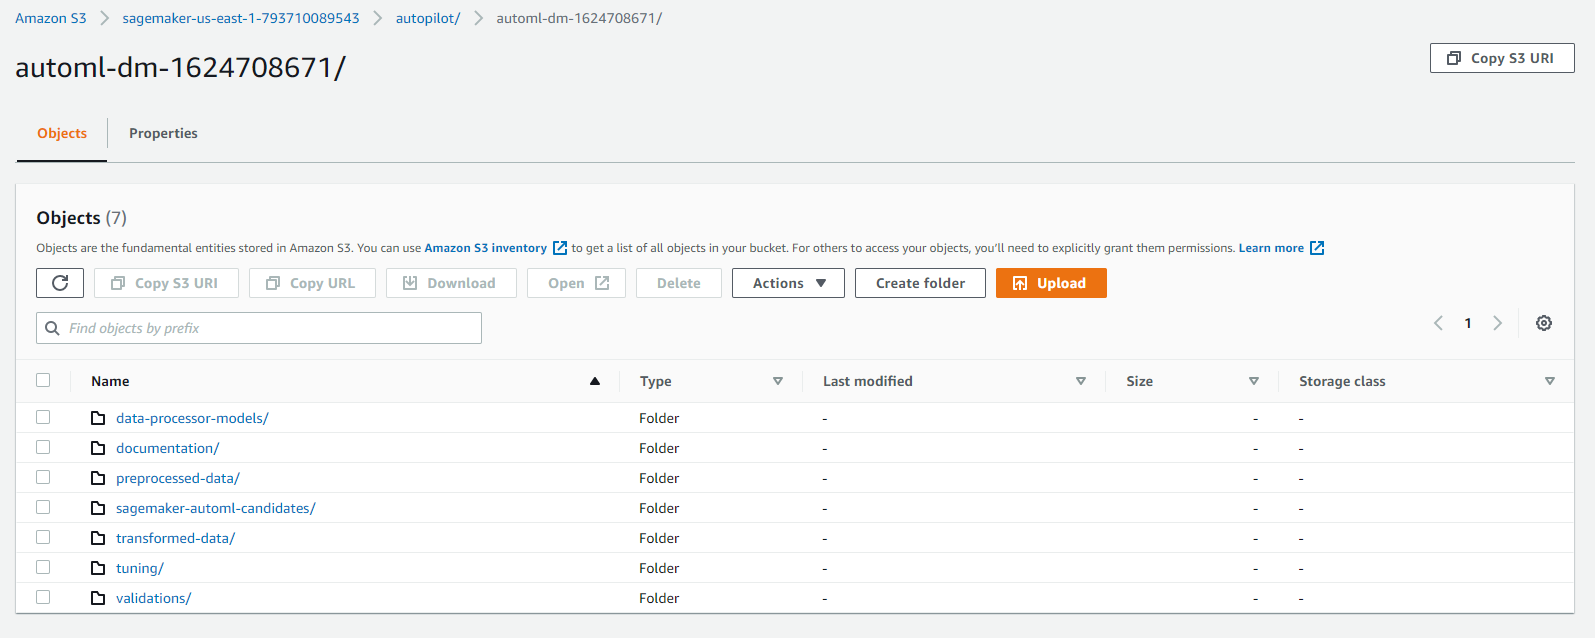

In [9]:
from IPython.display import Image
Image(filename='snapshots/final_files.png')

## Deploy and test best candidate model

### Deploy best candidate model

The best model will be deployed as a REST endpoint.

In [42]:
inference_response_keys = ['predicted_label', 'probability']

In [44]:
autopilot_model = automl.deploy(
    initial_instance_count=1,
    instance_type='ml.m5.large',
    candidate=best_candidate,
    inference_response_keys=inference_response_keys,
    predictor_cls=sagemaker.predictor.Predictor,
    serializer=sagemaker.serializers.JSONSerializer(),
    deserializer=sagemaker.deserializers.JSONDeserializer()
)

print('\nEndpoint name:  {}'.format(autopilot_model.endpoint_name))


-----------------!
Endpoint name:  sagemaker-sklearn-automl-2021-06-26-12-37-08-433


## Review the SageMaker endpoint in the AWS console.

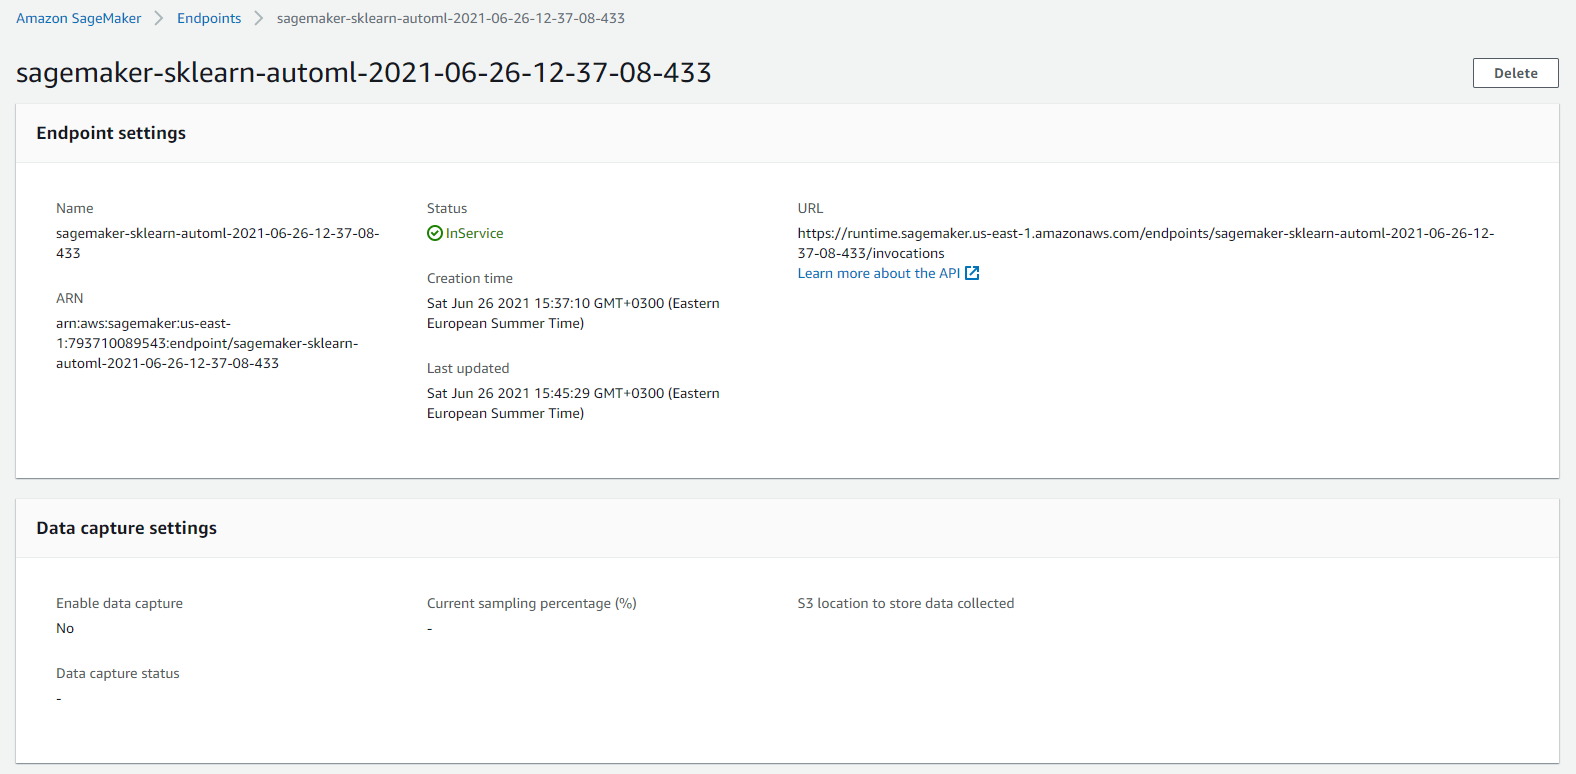

In [10]:
from IPython.display import Image
Image(filename='snapshots/endpoint.png')


## Test the model

Invoke a few predictions for the actual reviews using the deployed endpoint.

In [46]:
sm_runtime = boto3.client('sagemaker-runtime')

review_list = ['This product is great!',
               'OK, but not great.',
               'This is not the right product.']

for review in review_list:
    
    # remove commas from the review since we're passing the inputs as a CSV
    review = review.replace(",", "")

    response = sm_runtime.invoke_endpoint(
        EndpointName=autopilot_model.endpoint_name, # endpoint name
        ContentType='text/csv', # type of input data
        Accept='text/csv', # type of the inference in the response
        Body=review # review text
        )

    response_body=response['Body'].read().decode('utf-8').strip().split(',')

    print('Review: ', review, ' Predicated class: {}'.format(response_body[0]))

print("(-1 = Negative, 0=Neutral, 1=Positive)")


Review:  This product is great!  Predicated class: 1
Review:  OK but not great.  Predicated class: 0
Review:  This is not the right product.  Predicated class: 1
(-1 = Negative, 0=Neutral, 1=Positive)
